<a href="https://colab.research.google.com/github/Sarvagya4/Banking77/blob/main/BERT_finetunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers[torch] datasets pandas scikit-learn wandb evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 188.7/188.7 MB 123.0 MB/s eta 0:00:01

In [ ]:
import os
import pandas as pd
import numpy as np
from getpass import getpass


import torch
import wandb
import evaluate
from datasets import Dataset, DatasetDict

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = "/content/drive/MyDrive/Banking77_Project"
except ImportError:
    BASE_DIR = "./Banking77_Project"
    print("Not in Google Colab. Using local directory for project files.")

DATA_DIR = os.path.join(BASE_DIR, "data")
MODEL_DIR = os.path.join(BASE_DIR, "models", "bert-full-finetune")
os.makedirs(MODEL_DIR, exist_ok=True)

print(f"Project directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Model will be saved in: {MODEL_DIR}")

Mounted at /content/drive
Project directory: /content/drive/MyDrive/Banking77_Project
Data directory: /content/drive/MyDrive/Banking77_Project/data
Model will be saved in: /content/drive/MyDrive/Banking77_Project/models/bert-full-finetune


In [ ]:
!find /content/drive/MyDrive -type f -name "train.csv"


/content/drive/MyDrive/Banking77_Project/data/train.csv


In [ ]:
import os

DATA_DIR = "/content/drive/MyDrive/Banking77_Project/data"
print(os.listdir(DATA_DIR))


['train.csv', 'validation.csv', 'test.csv']


In [ ]:
try:
    wandb_key = getpass("Enter your Weights & Biases API key: ")
    wandb.login(key=wandb_key)
except Exception as e:
    print(f"Could not log in to W&B. Please check your API key. Error: {e}")

Enter your Weights & Biases API key: ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sarvagyatayal (Banking77) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
val_df = pd.read_csv(os.path.join(DATA_DIR, 'validation.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

In [ ]:
id2label = {i: label for i, label in enumerate(train_df['intent'].astype('category').cat.categories)}
label2id = {label: i for i, label in id2label.items()}
NUM_LABELS = len(id2label)

In [ ]:
train_df.rename(columns={'intent': 'label'}, inplace=True)
val_df.rename(columns={'intent': 'label'}, inplace=True)
test_df.rename(columns={'intent': 'label'}, inplace=True)

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print("Datasets loaded successfully:")
print(dataset_dict)

Datasets loaded successfully:
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'text_cleaned'],
        num_rows: 8002
    })
    validation: Dataset({
        features: ['text', 'label', 'text_cleaned'],
        num_rows: 2001
    })
    test: Dataset({
        features: ['text', 'label', 'text_cleaned'],
        num_rows: 3080
    })
})


In [ ]:
run = wandb.init(
    project="Banking77-Intent-Classification",
    job_type="train",
    name="day2-bert-full-finetune",
    notes="Fine-tuning a standard BERT model on the Banking77 dataset."
)

In [ ]:
MODEL_NAME = "bert-base-uncased"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize_function(examples):
    # Use the 'text_cleaned' column created in Day 1.
    return tokenizer(examples["text_cleaned"], padding="max_length", truncation=True)

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)
print("\nDatasets tokenized:")
print(tokenized_datasets)

Map:   0%|          | 0/8002 [00:00<?, ? examples/s]

Map:   0%|          | 0/2001 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]


Datasets tokenized:
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'text_cleaned', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8002
    })
    validation: Dataset({
        features: ['text', 'label', 'text_cleaned', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2001
    })
    test: Dataset({
        features: ['text', 'label', 'text_cleaned', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3080
    })
})


In [ ]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")

    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"],
    }

In [ ]:
training_args = TrainingArguments(
    output_dir=MODEL_DIR,
    num_train_epochs=6,  # A common starting point for fine-tuning
    learning_rate=1e-5,  # A standard learning rate for BERT fine-tuning[14]
    lr_scheduler_type="linear",  # or "cosine"
    warmup_ratio=0.1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    eval_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",        # Save a checkpoint at the end of each epoch
    load_best_model_at_end=True,  # The best model will be loaded at the end of training
    metric_for_best_model="f1",
    logging_dir=f"{MODEL_DIR}/logs",
    logging_steps=100,
    fp16=True,
    report_to="wandb"  # This is crucial for W&B integration[18]
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-3029316986.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
print("Starting model training...")
trainer.train()
print("Training finished.")

Starting model training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,3.818200,3.581690,0.254373,0.178236
2,2.620300,2.375874,0.683658,0.648898
3,1.877000,1.705462,0.775112,0.753473
4,1.442800,1.346659,0.828586,0.815657
5,1.261600,1.166769,0.837581,0.828035
6,1.109500,1.108825,0.843578,0.835301


Training finished.


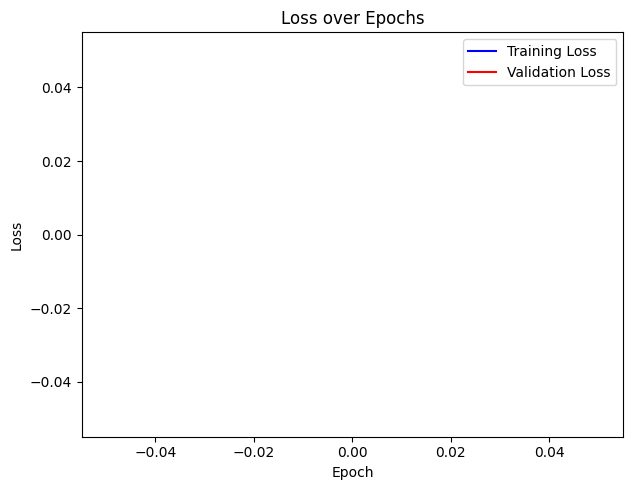

In [ ]:
import matplotlib.pyplot as plt

# Example training history structure
# Replace these with the lists you populate during training
train_losses = []  # append training loss each epoch
val_losses = []    # append validation loss each epoch
train_acc = []     # append training accuracy each epoch
val_acc = []       # append validation accuracy each epoch

# Example: after your training loop is done, visualize it
def plot_training_history(train_losses, val_losses, train_acc=None, val_acc=None):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Accuracy plot
    if train_acc and val_acc:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
        plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy over Epochs')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Example call after training
plot_training_history(train_losses, val_losses, train_acc, val_acc)


Epoch 1/10 - Train Loss: 2.3401, Train Acc: 0.0860, Val Loss: 2.3339, Val Acc: 0.1100
Epoch 2/10 - Train Loss: 2.2551, Train Acc: 0.1400, Val Loss: 2.3254, Val Acc: 0.0900
Epoch 3/10 - Train Loss: 2.1982, Train Acc: 0.2020, Val Loss: 2.3212, Val Acc: 0.0800
Epoch 4/10 - Train Loss: 2.1363, Train Acc: 0.2960, Val Loss: 2.3247, Val Acc: 0.1000
Epoch 5/10 - Train Loss: 2.0823, Train Acc: 0.3480, Val Loss: 2.3240, Val Acc: 0.1100
Epoch 6/10 - Train Loss: 2.0264, Train Acc: 0.3980, Val Loss: 2.3325, Val Acc: 0.1100
Epoch 7/10 - Train Loss: 1.9643, Train Acc: 0.4560, Val Loss: 2.3405, Val Acc: 0.1100
Epoch 8/10 - Train Loss: 1.8989, Train Acc: 0.5300, Val Loss: 2.3487, Val Acc: 0.1000
Epoch 9/10 - Train Loss: 1.8287, Train Acc: 0.5600, Val Loss: 2.3580, Val Acc: 0.1100
Epoch 10/10 - Train Loss: 1.7545, Train Acc: 0.6060, Val Loss: 2.3770, Val Acc: 0.1200


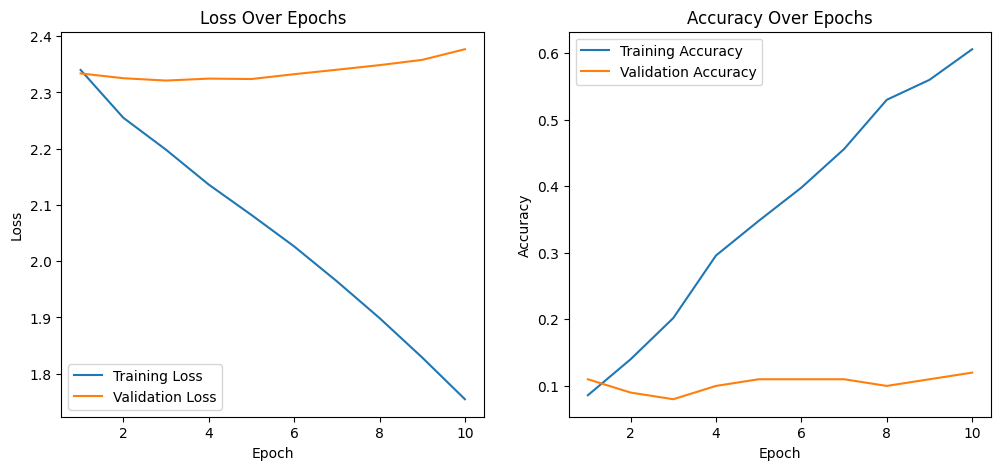

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# ----- 1. Dummy dataset (replace with your real one) -----
X_train = torch.randn(500, 100)  # 500 samples, 100 features
y_train = torch.randint(0, 10, (500,))  # 10 classes
X_val = torch.randn(100, 100)
y_val = torch.randint(0, 10, (100,))

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

# ----- 2. Simple model -----
model = nn.Sequential(
    nn.Linear(100, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ----- 3. Lists to store metrics -----
train_losses, val_losses = [], []
train_acc, val_acc = [], []

# ----- 4. Training loop -----
epochs = 10
for epoch in range(epochs):
    # Training
    model.train()
    total_loss, correct, total = 0, 0, 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_acc.append(correct / total)

    # Validation
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    val_losses.append(total_loss / len(val_loader))
    val_acc.append(correct / total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

# ----- 5. Visualization -----
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.show()

